In [1]:
import sys
from sparta.Auxil.PeriodicityDetector import PeriodicityDetector
from sparta.UNICOR.Spectrum import Spectrum
from sparta.UNICOR.Template import Template
from sparta.Auxil.TimeSeries import TimeSeries
from sparta.Observations import Observations
import numpy as np
from scipy import interpolate
from PyAstronomy import pyasl
import matplotlib.pyplot as plt
from scipy import signal
from scipy.ndimage import filters
import copy as cp
import pandas as pd
import pickle


In [24]:
def peak_picking_MSAF(x, median_len=10, offset_rel=0.2, sigma=1e-4):
    """ Peak picking strategy following MSFA using an adaptive threshold (https://github.com/urinieto/msaf)
        Adapted to negative peaks too.

    Args:
        x (np.ndarray): Input function
        median_len (int): Length of media filter used for adaptive thresholding (Default value = 16)
        offset_rel (float): Additional offset used for adaptive thresholding (Default value = 0.0)
        sigma (float): Variance for Gaussian kernel used for smoothing the novelty function (Default value = 4.0)

    Returns:
        peaks (np.ndarray): Peak positions
        x (np.ndarray): Local threshold
        threshold_local (np.ndarray): Filtered novelty curve
    """
    offset = x.mean() * offset_rel
    x = filters.gaussian_filter1d(x, sigma=sigma)
    threshold_local = filters.median_filter(x, size=median_len) + offset
    peaks = []
    for i in range(1, x.shape[0] - 1):
        if x[i - 1] < x[i] and x[i] > x[i + 1] and x[i] > threshold_local[i]:
                peaks.append(i)
        if x[i - 1] > x[i] and x[i] < x[i + 1] and x[i] < -threshold_local[i]:
                peaks.append(i)
    peaks = np.array(peaks)
    
    return peaks, x, threshold_local

In [25]:
def plot_signal(x, Fs=1, T_coef=None, ax=None, figsize=(18, 6), xlabel='Frequency [1/day]', ylabel='', title='', dpi=72,
                ylim=True, **kwargs):
    """Line plot visualization of a signal, e.g. a waveform or a novelty function.

    Args:
        x: Input signal
        Fs: Sample rate (Default value = 1)
        T_coef: Time coeffients. If None, will be computed, based on Fs. (Default value = None)
        ax: The Axes instance to plot on. If None, will create a figure and axes. (Default value = None)
        figsize: Width, height in inches (Default value = (6, 2))
        xlabel: Label for x axis (Default value = 'Time (seconds)')
        ylabel: Label for y axis (Default value = '')
        title: Title for plot (Default value = '')
        dpi: Dots per inch (Default value = 72)
        ylim: True or False (auto adjust ylim or nnot) or tuple with actual ylim (Default value = True)
        **kwargs: Keyword arguments for matplotlib.pyplot.plot

    Returns:
        fig: The created matplotlib figure or None if ax was given.
        ax: The used axes.
        line: The line plot
    """
    fig = None
    if ax is None:
        fig = plt.figure(figsize=figsize, dpi=dpi)
        ax = plt.subplot(1, 1, 1)
    # if T_coef is None:
    #     T_coef = np.arange(x.shape[0]) / Fs

    if 'color' not in kwargs:
        kwargs['color'] = 'gray'

    line = ax.plot(x, **kwargs)

    #ax.set_xlim([T_coef[0], T_coef[-1]])
    if ylim is True:
        ylim_x = x[np.isfinite(x)]
        x_min, x_max = ylim_x.min(), ylim_x.max()
        if x_max == x_min:
            x_max = x_max + 1
        ax.set_ylim([min(1.1 * x_min, 0.9 * x_min), max(1.1 * x_max, 0.9 * x_max)])
    elif ylim not in [True, False, None]:
        ax.set_ylim(ylim)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    if fig is not None:
        plt.tight_layout()

    return fig, ax, line

In [26]:
def plot_function_peak_positions(nov, Fs_nov, peaks, title='', figsize=(18,6)):
    peaks_sec = peaks/Fs_nov
    fig, ax, line = plot_signal(nov, Fs_nov, figsize=figsize, color='k', title=title);
    plt.vlines(peaks_sec, 0, 1.1, color='r', linestyle=':', linewidth=1);

In [2]:
# plot the periodograms by opening the pickle file

file = open(r'C:\Users\kentb\Desktop\PDM\thesis\main\S1D\results\BGCru5600_5800.pkl', "rb")
obs_data = pickle.load(file)
file.close()

In [17]:
freq = np.asarray(obs_data.periodicity_detector.results_frequency['shift_periodogram'])
power = np.asarray(obs_data.periodicity_detector.results_power['shift_periodogram'])
signal = np.column_stack([freq, power])

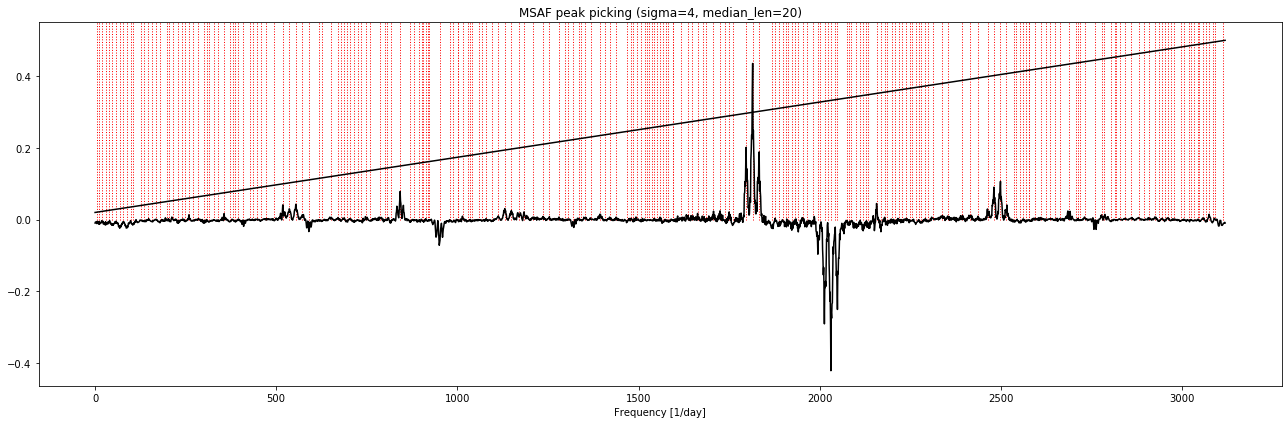

In [31]:
sigma = 4
median_len = 20

peaks, x_smooth, threshold_local = peak_picking_MSAF(power, median_len=median_len, offset_rel=0.1, sigma=sigma)
title='MSAF peak picking (sigma=%1.0f, median_len=%2.0f)'%(sigma, median_len)
plot_function_peak_positions(nov = signal,Fs_nov=1, peaks=peaks, title=title)


not good... Need to find a better  way to find the peaks and to remove them.

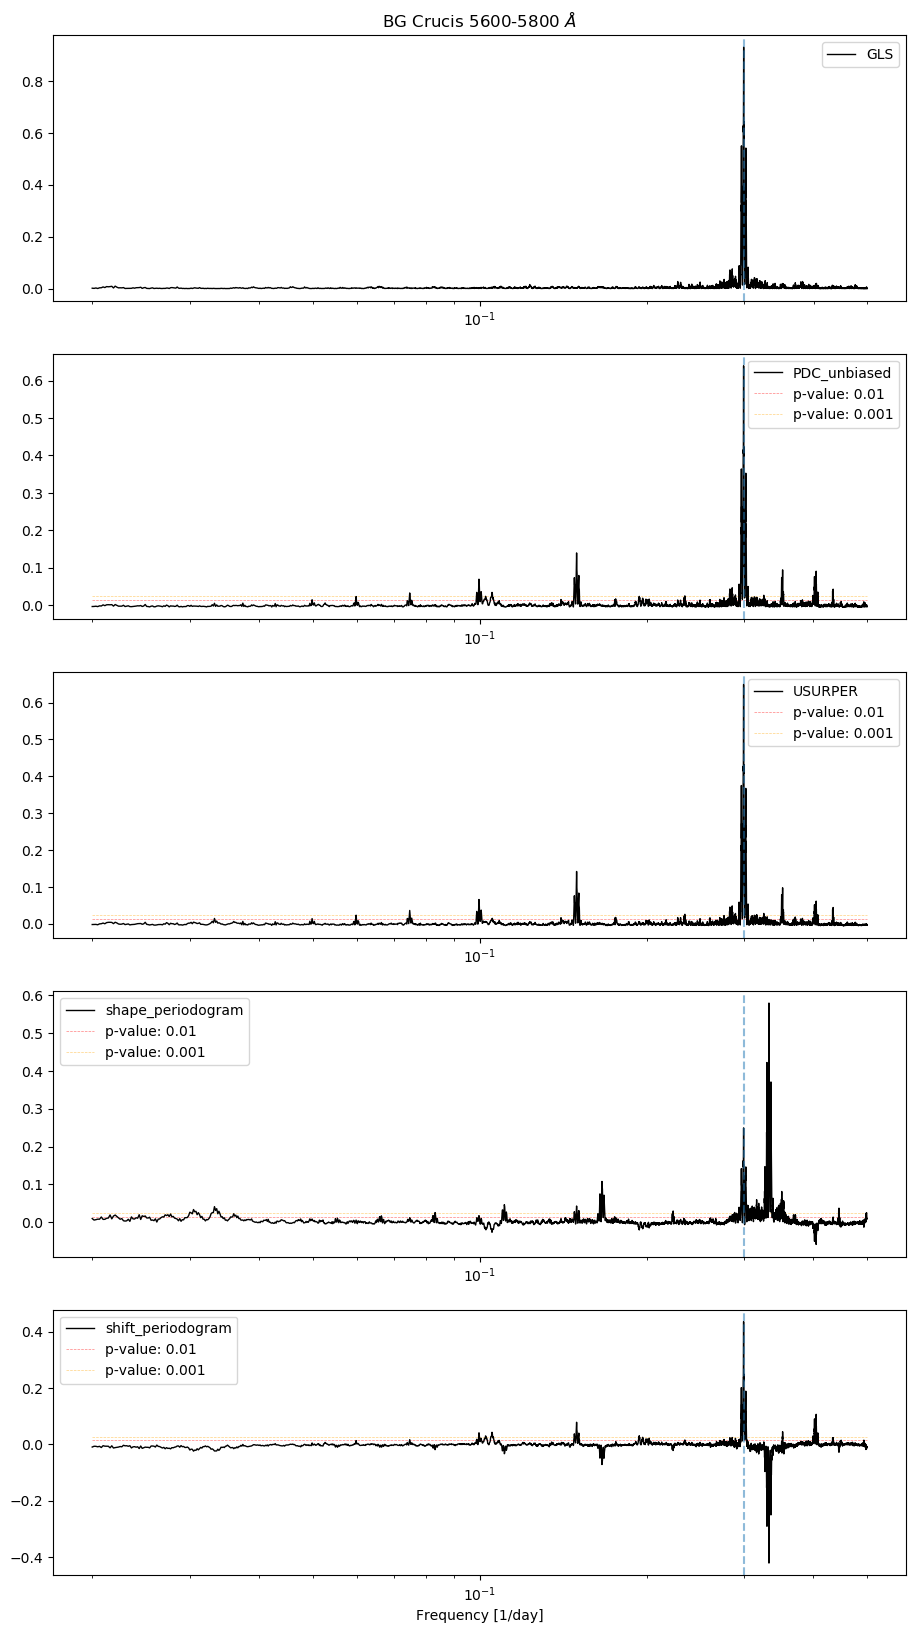

In [3]:
obs_data.periodicity_detector.plot_periodograms(annotate_pval=[1e-2,1e-3], plot_vals=False,title=r"BG Crucis 5600-5800 $\AA$", log_scale=True)

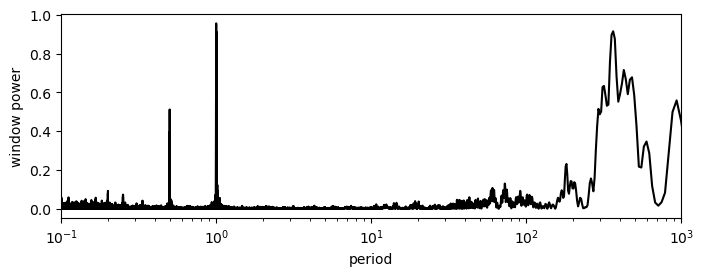

In [50]:
from astropy.timeseries import LombScargle
ls = LombScargle(obs_data.time_series.times,1,fit_mean=False,center_data=False)

freqW, powerW = ls.autopower(minimum_frequency=1/3000, maximum_frequency=50)

fig, ax = plt.subplots(figsize=(8, 3))
fig.subplots_adjust(bottom=0.2)
ax.set_xscale('log')
ax.plot(1. / freqW, powerW, '-k', rasterized=True)

ax.set(xlabel='period',
       ylabel='window power',
       xlim=(0.1, 1000));


In [38]:
peaks = signal.find_peaks(powerW, prominence=0.4)

In [63]:
# plot the periodograms by opening the pickle file

file = open(r'C:\Users\kentb\Desktop\PDM\thesis\main\S1D\results\BGCru_4000_6000.pkl', "rb")
obs_data = pickle.load(file)
file.close()

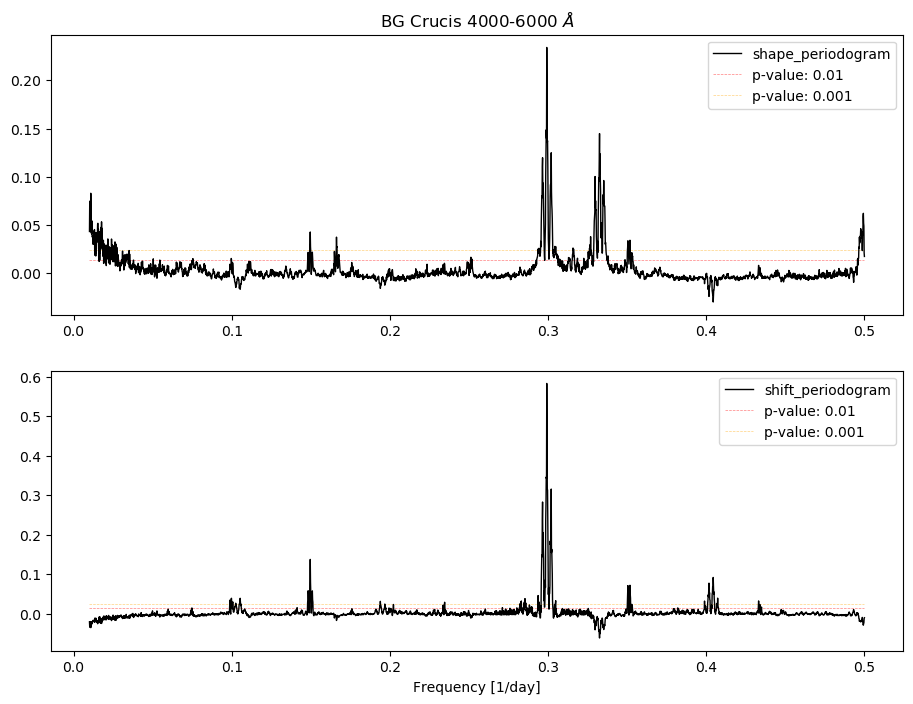

In [64]:
obs_data.periodicity_detector.plot_periodograms(annotate_pval=[1e-2,1e-3], plot_vals=False,title=r"BG Crucis 4000-6000 $\AA$", log_scale=False)

In [51]:
import os

In [54]:
# Plot all periodograms in a single plot by opening each pickle file and adding a subplot

results_dir = "C:\\Users\\kentb\\Desktop\\PDM\\thesis\\main\\S1D\\results\\"
results_files = sorted([folder for folder in os.listdir(results_dir) if os.path.isfile(os.path.join(results_dir, folder))])

In [55]:
print(results_files)

['BGCru_4000_6000.pkl', 'BGCru_4200_4400.pkl', 'BGCru_4400_4600.pkl', 'BGCru_4600_4800.pkl', 'BGCru_4800_5000.pkl', 'BGCru_5000_5200.pkl', 'BGCru_5200_5400.pkl', 'BGCru_5400_5600.pkl', 'BGCru_5600_5800.pkl', 'BGCru_5800_6000.pkl', 'QZNor_4000_6000.pkl', 'QZNor_4200_4400.pkl', 'QZNor_4400_4600.pkl', 'QZNor_4600_4800.pkl', 'QZNor_4800_5000.pkl', 'QZNor_5000_5200.pkl', 'QZNor_5200_5400.pkl', 'QZNor_5400_5600.pkl', 'QZNor_5600_5800.pkl', 'QZNor_5800_6000.pkl', 'V0391_4000_6000.pkl', 'V0391_4200_4400.pkl', 'V0391_4400_4600.pkl', 'V0391_4600_4800.pkl', 'V0391_4800_5000.pkl', 'V0391_5000_5200.pkl', 'V0391_5200_5400.pkl', 'V0391_5400_5600.pkl', 'V0391_5600_5800.pkl', 'V0391_5800_6000.pkl']


In [ ]:
for file in results_files:
    file = open(results_dir + file, "rb")
    obs_data = pickle.load(file)
    obs_data.periodicity_detector.plot_periodograms(annotate_pval=[1e-2,1e-3], plot_vals=False,title=str(file).split('\\')[-1], log_scale=False)
    file.close()